In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torchsummary
import yaml
import albumentations as A
from albumentations.augmentations.geometric.transforms import Flip

from src.utils import load_pretrained_model
from src.datamodule import CONICDataModule

In [2]:
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)
    
cfg

{'data_dir': 'data',
 'images_path': 'data/images.npy',
 'labels_path': 'data/labels.npy',
 'pretrained_model_path': 'models/tenpercent_resnet18.ckpt'}

In [3]:
print(torch.cuda.is_available())
device = 'cuda:0'

True


In [4]:
# Load data
images = np.load(cfg['images_path'])
labels = np.load(cfg['labels_path'])
images.shape, labels.shape

((4981, 256, 256, 3), (4981, 256, 256, 2))

In [5]:
# Load model
model = load_pretrained_model(path=cfg['pretrained_model_path'], device=device)
print(type(model))

/home/gptrapletti/ds/.miniconda/envs/hist/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gptrapletti/ds/.miniconda/envs/hist/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<class 'torchvision.models.resnet.ResNet'>


In [6]:
torchsummary.summary(model, input_size=(3, 256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

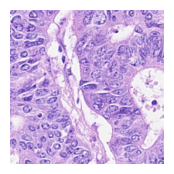

In [7]:
# Image example
img = images[0]

plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
# Test prediction (returns embeddings)
img_t = torch.tensor(img).permute(2, 0, 1) / 255. # to tensor
img_t = img_t[None, ...] # add batch dimension
out = model(img_t) 
out.shape

torch.Size([1, 512])

## HOW MUCH PRUNE

In [9]:
# Access the model's layers
layers = [x for x in model.children()]
len(layers)

10

In [10]:
# Prune model to return feature maps
how_much = 5
model2 = torch.nn.Sequential(*list(model.children())[:-how_much])
out = model2(img_t)
out.shape

torch.Size([1, 64, 64, 64])

## TEST ALBUMENTATIONS

In [11]:
is_pc = np.any(labels[..., 1]==4, axis=(1, 2))
pc_idxs = np.where(is_pc) # np.where() without condition just return the indexes of the non-zero elements
images, labels = images[pc_idxs], labels[pc_idxs]
# Keep only semantic segmentation channel and turn to binary masks
labels = labels[..., 1]
labels = np.where(labels==4, 1, 0)

images.shape, labels.shape

((3316, 256, 256, 3), (3316, 256, 256))

In [12]:
idx = 0

In [13]:
transforms = A.Compose([
    Flip(p=1),
    A.transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1))
])

In [14]:
r = transforms(image=images[idx], mask=labels[idx])

# normalization is not applied to the mask

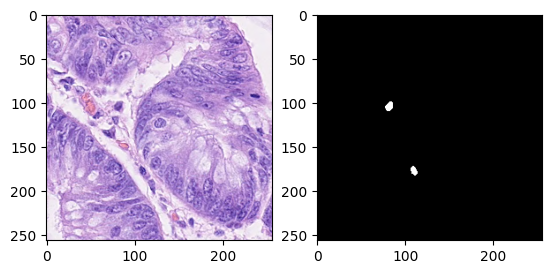

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(images[idx])
ax2.imshow(labels[idx], cmap='gray')
plt.show()

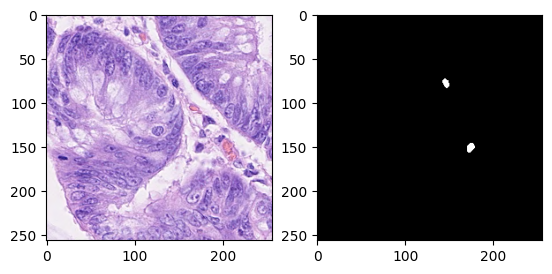

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(r['image'])
ax2.imshow(r['mask'], cmap='gray')
plt.show()

In [17]:
t = A.Compose([
    A.transforms.Normalize(mean=(0), std=(1))
])

transformed_mask = t(image=labels[0])['image']

In [18]:
np.unique(transformed_mask)

# normalization is aplied to the mask

array([0.        , 0.00392157], dtype=float32)

## DATAMODULE

In [19]:
datamodule = CONICDataModule(data_dir=cfg['data_dir'], biomarker=2)

In [20]:
datamodule.prepare_data()

In [21]:
datamodule.setup('fit')

In [22]:
train_ds = datamodule.train_ds
len(train_ds)

3404

In [23]:
a = train_ds[0][1]
a.sum()

tensor(3094)

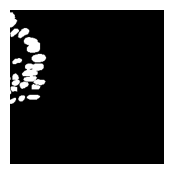

In [24]:
plt.figure(figsize=(2, 2))
plt.imshow(torch.where(a!=0, 1, 0), cmap='gray') # from normalized to binary
plt.axis('off')
plt.show()

In [25]:
train_dl = datamodule.train_dataloader()

In [26]:
len(train_dl)

107

In [27]:
a = next(iter(train_dl))

In [28]:
type(a), len(a), type(a[0]), type(a[1]), a[0].shape, a[1].shape

(list,
 2,
 torch.Tensor,
 torch.Tensor,
 torch.Size([32, 3, 256, 256]),
 torch.Size([32, 256, 256]))

## LOAD ENCODER

In [29]:
from src.model import SegEncoder

In [35]:
encoder = SegEncoder(ckpt_path=cfg['pretrained_model_path'], pruning=3)
out = encoder(img_t)
out.shape

torch.Size([1, 256, 16, 16])

## TESTS WITH UPCONV LAYERS

In [2]:
input_size = 16
kernel_size = 3
padding = 0
stride = 1

((input_size - kernel_size + (2 * padding)) / stride) + 1

14.0

In [20]:
# input = torch.randn(size=[256, 16, 16])
input = torch.randn(size=[128, 32, 32])

layer1 = nn.ConvTranspose2d(
    in_channels=input.shape[0], 
    out_channels=int(input.shape[0]/2),
    kernel_size=2,
    stride=2,
    padding=0
)

output1 = layer1(input)
output1.shape

torch.Size([64, 64, 64])

In [21]:
layer2 = nn.Conv2d(
    in_channels=output1.shape[0],
    out_channels=int(output1.shape[0]/2),
    kernel_size=3,
    stride=1,
    padding=1
)

output2 = layer2(output1)
output2.shape

torch.Size([32, 64, 64])